<a href="https://colab.research.google.com/github/m4dhv/terafac/blob/main/level_3_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**LEVEL 3: Advanced Architecture Design (CIFAR-10)**

1. Importing dependencies

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


2. Data Augmentation

In [ ]:
BATCH_SIZE = 128
EPOCHS = 20
NUM_WORKERS = 2

mean = (0.4914, 0.4822, 0.4465)
std  = (0.2470, 0.2435, 0.2616)

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomErasing(p=0.25)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_ds = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
test_ds  = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

classes = train_ds.classes
print("Classes:", classes)


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


3. Multi task Label Mapping

In [ ]:
# CIFAR-10 class order:
# 0 airplane, 1 automobile, 2 bird, 3 cat, 4 deer, 5 dog, 6 frog, 7 horse, 8 ship, 9 truck

animal_classes = {2,3,4,5,6,7}
vehicle_classes = {0,1,8,9}

def aux_label(y):
    # 0 = vehicle, 1 = animal
    if int(y) in animal_classes:
        return 1
    return 0


4. SE Block and Residual SE Block

In [ ]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        b, c, h, w = x.shape
        s = x.mean(dim=(2,3))               # Global Avg Pool -> (B, C)
        s = F.relu(self.fc1(s))
        s = torch.sigmoid(self.fc2(s))
        s = s.view(b, c, 1, 1)
        return x * s


In [ ]:
class ResidualSEBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)

        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)

        self.se = SEBlock(out_ch)

        self.skip = None
        if in_ch != out_ch or stride != 1:
            self.skip = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)

        if self.skip is not None:
            identity = self.skip(identity)

        out = F.relu(out + identity)
        return out


5. Custom model with multi-task heads

In [ ]:
class CIFARAttentionNet(nn.Module):
    def __init__(self, num_classes=10, aux_classes=2):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            ResidualSEBlock(64, 64),
            ResidualSEBlock(64, 64),
        )

        self.layer2 = nn.Sequential(
            ResidualSEBlock(64, 128, stride=2),
            ResidualSEBlock(128, 128),
        )

        self.layer3 = nn.Sequential(
            ResidualSEBlock(128, 256, stride=2),
            ResidualSEBlock(256, 256),
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.dropout = nn.Dropout(0.25)

        # Main head (CIFAR-10)
        self.fc_main = nn.Linear(256, num_classes)

        # Aux head (animal vs vehicle)
        self.fc_aux = nn.Linear(256, aux_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        feat = self.pool(x).flatten(1)
        feat = self.dropout(feat)

        main_logits = self.fc_main(feat)
        aux_logits = self.fc_aux(feat)

        return main_logits, aux_logits


In [ ]:
model = CIFARAttentionNet(num_classes=10, aux_classes=2).to(device)

criterion_main = nn.CrossEntropyLoss(label_smoothing=0.1)
criterion_aux  = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

LAMBDA_AUX = 0.2


6. Training and Evaluation functions

In [ ]:
def train_one_epoch(model, loader):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for x, y in tqdm(loader, desc="Training", leave=False):
        x, y = x.to(device), y.to(device)

        y_aux = torch.tensor([aux_label(i) for i in y.cpu().numpy()], device=device)

        optimizer.zero_grad()
        out_main, out_aux = model(x)

        loss_main = criterion_main(out_main, y)
        loss_aux  = criterion_aux(out_aux, y_aux)

        loss = loss_main + LAMBDA_AUX * loss_aux
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        pred = out_main.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    return total_loss / total, 100.0 * correct / total


@torch.no_grad()
def eval_model(model, loader):
    model.eval()
    correct, total = 0, 0

    for x, y in tqdm(loader, desc="Evaluating", leave=False):
        x, y = x.to(device), y.to(device)
        out_main, _ = model(x)

        pred = out_main.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    return 100.0 * correct / total


In [ ]:
best_acc = 0

train_acc_list = []
test_acc_list = []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    train_loss, train_acc = train_one_epoch(model, train_loader)
    test_acc = eval_model(model, test_loader)

    scheduler.step()

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

    print(f"Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), "best_level3_cifar_attention.pth")
        print("Saved Best Model")

print("\n Best Test Accuracy:", best_acc)



Epoch 1/20


Train Acc: 46.23% | Test Acc: 50.70%
Saved Best Model

Epoch 2/20


Train Acc: 63.13% | Test Acc: 65.62%
Saved Best Model

Epoch 3/20


Train Acc: 70.21% | Test Acc: 71.63%
Saved Best Model

Epoch 4/20


Train Acc: 74.53% | Test Acc: 72.42%
Saved Best Model

Epoch 5/20


Train Acc: 77.40% | Test Acc: 77.80%
Saved Best Model

Epoch 6/20


Train Acc: 79.73% | Test Acc: 80.55%
Saved Best Model

Epoch 7/20


Train Acc: 81.49% | Test Acc: 82.67%
Saved Best Model

Epoch 8/20


Train Acc: 83.08% | Test Acc: 84.60%
Saved Best Model

Epoch 9/20


Train Acc: 84.22% | Test Acc: 81.89%

Epoch 10/20


Train Acc: 85.65% | Test Acc: 83.96%

Epoch 11/20


Train Acc: 86.66% | Test Acc: 86.14%
Saved Best Model

Epoch 12/20


Train Acc: 87.54% | Test Acc: 86.28%
Saved Best Model

Epoch 13/20


Train Acc: 88.58% | Test Acc: 87.85%
Saved Best Model

Epoch 14/20


Train Acc: 89.31% | Test Acc: 88.06%
Saved Best Model

Epoch 15/20


Train Acc: 90.08% | Test Acc: 88.82%
Saved Best Model

Epoch 16/20


Train Acc: 90.52% | Test Acc: 89.25%
Saved Best Model

Epoch 17/20


Train Acc: 91.34% | Test Acc: 89.43%
Saved Best Model

Epoch 18/20


Train Acc: 91.64% | Test Acc: 89.87%
Saved Best Model

Epoch 19/20


Train Acc: 92.11% | Test Acc: 89.92%
Saved Best Model

Epoch 20/20


Train Acc: 92.09% | Test Acc: 89.96%
Saved Best Model

 Best Test Accuracy: 89.96


7. Classification Report, Confusion Matrix and GradCAM

In [ ]:
@torch.no_grad()
def get_preds(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    for x, y in loader:
        x = x.to(device)
        out_main, _ = model(x)
        preds = out_main.argmax(dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(y.numpy())

    return np.array(all_labels), np.array(all_preds)

y_true, y_pred = get_preds(model, test_loader)

print(classification_report(y_true, y_pred, target_names=classes))


              precision    recall  f1-score   support

    airplane       0.90      0.92      0.91      1000
  automobile       0.96      0.96      0.96      1000
        bird       0.85      0.85      0.85      1000
         cat       0.81      0.78      0.79      1000
        deer       0.88      0.90      0.89      1000
         dog       0.85      0.84      0.85      1000
        frog       0.92      0.92      0.92      1000
       horse       0.93      0.92      0.93      1000
        ship       0.95      0.95      0.95      1000
       truck       0.95      0.95      0.95      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



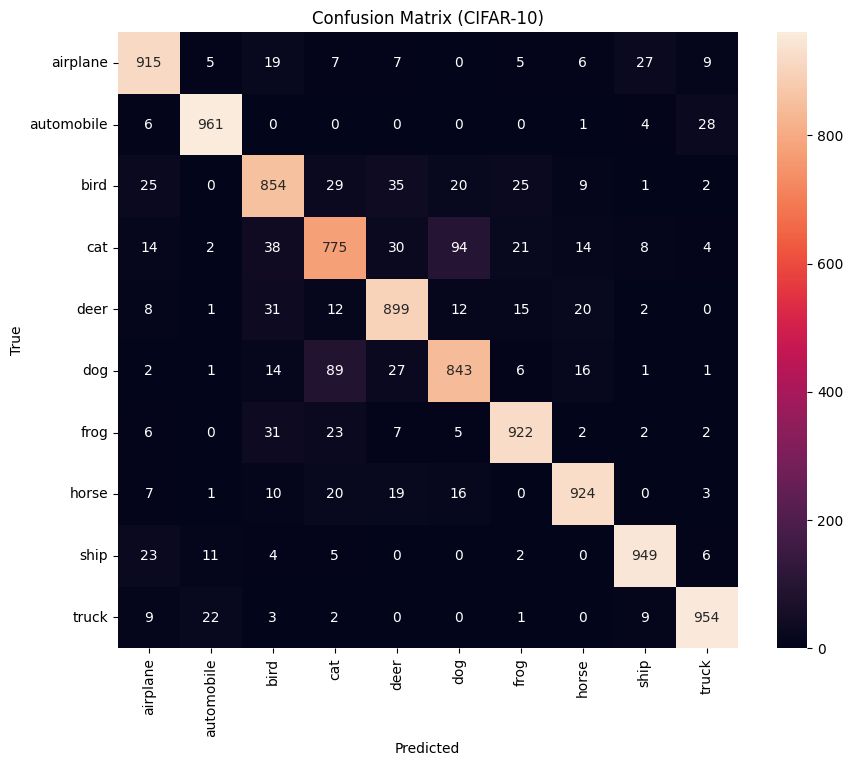

<Figure size 640x480 with 0 Axes>

In [47]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix (CIFAR-10)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
import os
os.makedirs("results", exist_ok=True)
plt.savefig("results/level3_confusion_matrix.png")

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, x, class_idx=None):
        self.model.zero_grad()
        out_main, _ = self.model(x)

        if class_idx is None:
            class_idx = out_main.argmax(dim=1).item()

        score = out_main[:, class_idx]
        score.backward()

        grads = self.gradients[0]      # (C,H,W)
        acts  = self.activations[0]    # (C,H,W)

        weights = grads.mean(dim=(1,2))
        cam = (weights[:, None, None] * acts).sum(dim=0)

        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam.detach().cpu().numpy(), class_idx


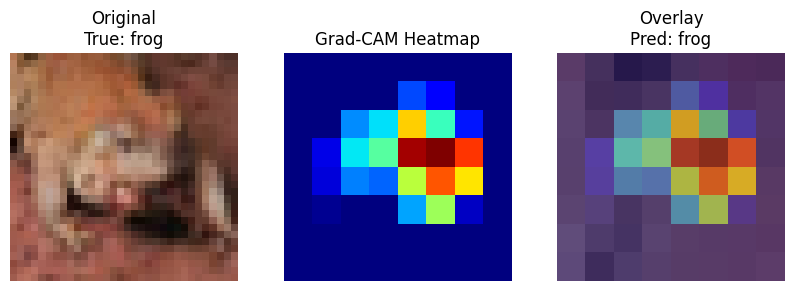

<Figure size 640x480 with 0 Axes>

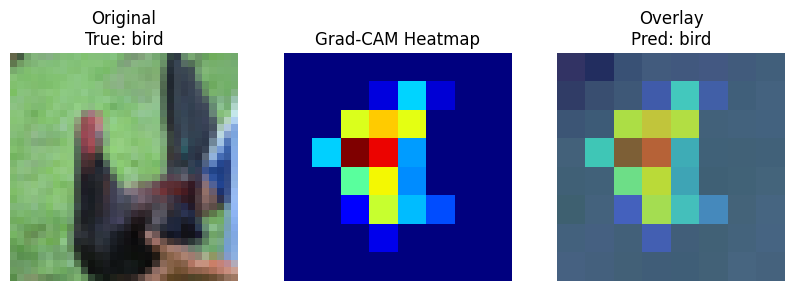

<Figure size 640x480 with 0 Axes>

In [48]:
def show_gradcam(model, dataset, idx=0):
    import os

    model.eval()

    img, label = dataset[idx]
    x = img.unsqueeze(0).to(device)

    cam_gen = GradCAM(model, model.layer3[-1].conv2)
    cam, pred_class = cam_gen.generate(x)


    img_np = img.permute(1,2,0).numpy()
    img_np = (img_np * np.array(std)) + np.array(mean)
    img_np = np.clip(img_np, 0, 1)

    plt.figure(figsize=(10,4))

    plt.subplot(1,3,1)
    plt.imshow(img_np)
    plt.title(f"Original\nTrue: {classes[label]}")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(cam, cmap="jet")
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(img_np)
    plt.imshow(cam, cmap="jet", alpha=0.5)
    plt.title(f"Overlay\nPred: {classes[pred_class]}")
    plt.axis("off")

    plt.show()
    os.makedirs("results", exist_ok=True)
    plt.savefig("results/level3_gradmap.png")

show_gradcam(model, test_ds, idx=5)
show_gradcam(model, test_ds, idx=25)


In [51]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
